In [2]:
from dotenv import load_dotenv
import os
import pandas as pd
from tqdm import tqdm
import json
import random

In [209]:
# loading variables from .env file
load_dotenv("../../private_data/.env") 

# PARENT gets us to the root of the project
PARENT = "./../../"

FOLDER_TABLE = PARENT + os.getenv("FOLDER_TABLE")
FILE_FABRITIUS_DATA = PARENT + os.getenv("FILE_FABRITIUS_DATA")
FILE_FABRITIUS_DATA_FILTERED = PARENT + os.getenv("FILE_FABRITIUS_DATA_FILTERED")
FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED = PARENT + os.getenv("FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED")
FOLDER_FIGURES = PARENT + os.getenv("FOLDER_FIGURES")
IMAGES_FOLDER = PARENT + os.getenv("IMAGES_FOLDER")
FOLDER_TABLE = PARENT + os.getenv("FOLDER_TABLE")
RECORD_IDS_TESTING_SET = PARENT + os.getenv("RECORD_IDS_TESTING_SET")
RECORD_IDS_VALIDATION_SET = PARENT + os.getenv("RECORD_IDS_VALIDATION_SET")
WRITTEN_CAPTIONS_TESTING_SET = PARENT + os.getenv("WRITTEN_CAPTIONS_TESTING_SET")
WRITTEN_CAPTIONS_VALIDATION_SET = PARENT + os.getenv("WRITTEN_CAPTIONS_VALIDATION_SET")
FILE_FABRITIUS_ICONOGRAPHIES_JSON = PARENT + os.getenv("FILE_FABRITIUS_ICONOGRAPHIES_JSON")
EMBEDDINGS_FOLDER = PARENT + os.getenv("EMBEDDINGS_FOLDER")
MODELS_FOLDER = PARENT + os.getenv("MODELS_FOLDER")

DB_INPUT_ARTPIECES = PARENT + os.getenv("DB_INPUT_ARTPIECES")
DB_INPUT_ARTISTS = PARENT + os.getenv("DB_INPUT_ARTISTS")
DB_INPUT_SUBJECTMATTER = PARENT + os.getenv("DB_INPUT_SUBJECTMATTER")
FILE_SUBJECTMATTERS_PARSED = PARENT + os.getenv("FILE_SUBJECTMATTERS_PARSED")

AUTHORS_PREDICTIONS = PARENT + os.getenv("AUTHORS_PREDICTIONS")

def get_db_config():
    return {
        "host": os.getenv("DB_HOST"),
        "port": os.getenv("DB_PORT"),
        "name": os.getenv("DB_NAME"),
        "user": os.getenv("DB_USER"),
        "password": os.getenv("DB_PASSWORD"),
    }

In [ ]:
delimiters = ["(", ")", ";", ":"]

class Node:
    def __init__(self, value, children=None, parent=None):
        self.value = value#lower()
        while self.value[0]==" ":
            self.value = self.value[1:]
        self.parent = parent
        
        if children is None:
            self.children = []
        else:
            self.children = children
            for child in children:
                child.set_parent(self)

        self.forgotten = False
    
    def setForgotten(self, forgotten):
        self.forgotten = forgotten

    def __hash__(self):
        return hash(self.value)
    
    def __eq__(self, other):
        return self.value == other.value

    def get_as_string(self, level=0):
        st = f"'{self.value}'"
        children_st = ",".join([child.get_as_string(level+1) for child in self.children])

        if self.value.startswith("<depth"):
            return children_st

        if len(self.children) > 0:
            st += f"[{children_st}]"

        return st

    def set_parent(self, parent):
        self.parent = parent

    def get_parent(self):
        return self.parent

    def add_child(self, child):
        self.children.append(child)
        child.set_parent(self)
    
    def print_tree(self, level=0):
        print("\t"*level + self.value)
        for child in self.children:
            child.print_tree(level+1)

    def get_children(self):
        return self.children
    
    def getUniqueLabels(self):
        labels = set()
        labels.add(self.value)
        for child in self.children:
            labels.update(child.getUniqueLabels())
        return labels
    
    def remove_empty_children(self):
        newChildren = []
        for child in self.children:
            if len(child.children) > 0:
                newChildren.append(child)
        self.children = newChildren

    def as_json(self, depth=0):
        return {
            "name": self.value,
            "children": [child.as_json(depth=depth + 1) for child in self.children],
        }
    
    def as_flattened_values(self):
        if self.value in ["<group>", "<depth>", "root"]:
            values = []
        else:
            values = [self.value]
        for child in self.children:
            values += child.as_flattened_values()
        return values
        

def cleanIconography(iconography):
    while "  " in iconography:
        iconography = iconography.replace("  ", " ")
    for delimiter in delimiters + ["/"]:
        iconography = iconography.replace(delimiter, f" {delimiter}")
        iconography = iconography.replace(delimiter, f"{delimiter} ")
    return iconography

def l1(elements, parent):
    e1 = elements[0]
    if e1 not in delimiters:
        parent.add_child(Node(e1))
    
def l2(elements, parent):
    # S )
    # ; S
    # : S
    e1 = elements[0]
    e2 = elements[1]

    rule1 = (e1 not in delimiters) and (e2==")")
    if rule1:
        parent.add_child(Node(e1))
        return
    
    rule2 = (e1==";") and (e2 not in delimiters)
    if rule2:
        parent.add_child(Node(e2))
        return
    
    rule3 = (e1==":") and (e2 not in delimiters)
    if rule3:
        lastChild = parent.children[-1]
        lastChild.add_child(Node(e2))
        return

def explorer(elements, parent):

    L = len(elements)
    if L==0:
        return
    if L==1:
        return l1(elements, parent)
    if L==2:
        return l2(elements, parent)

    e1 = elements[0]
    e2 = elements[1]
    e3 = elements[2]

    # S ; S
    rule1 = (e1 not in delimiters) and (e2==";") and (e3 not in delimiters)
    if rule1:
        parent.add_child(Node(e1))
        return explorer(elements[2:], parent)
    
    # S : S
    rule2 = (e1 not in delimiters) and (e2==":") and (e3 not in delimiters)
    if rule2:
        newNode = Node(e1)
        parent.add_child(newNode)
        newNode.add_child(Node(e3))
        return explorer(elements[3:], parent)
    
    # S ( S
    rule3 = (e1 not in delimiters) and (e2=="(") and (e3 not in delimiters)
    if rule3:
        newNode = Node(e1)
        parent.add_child(newNode)
        return explorer(elements[2:], newNode)

    # S ) E
    rule4 = (e1 not in delimiters) and (e2==")")
    if rule4:
        parent.add_child(Node(e1))
        return explorer(elements[2:], parent.get_parent())
    
    # S ; E
    rule5 = (e1 not in delimiters) and (e2==";")
    if rule5:
        # A litte trick: We add a new node after ';' since we know that E is not a S
        # We add <group> after ;
        parent.add_child(Node(e1))
        return explorer(["<group>"] + elements[2:], parent)

    # ; ( E
    rule6 = (e1==";") and (e2=="(")
    if rule6:
        # A litte trick: We add a new node after ';' to create a new group
        # We add <group> after ;
        return explorer(["<group>"] + elements[1:], parent)

    # ; S )
    rule7 = (e1==";") and (e2 not in delimiters) and (e3==")")
    if rule7:
        parent.add_child(Node(e2))
        return explorer(elements[3:], parent.get_parent())
    
    # ; S E
    rule8 = (e1==";") and (e2 not in delimiters)
    if rule8:
        return explorer(elements[1:], parent)

    # : S E
    rule9 = (e1==":") and (e2 not in delimiters)
    if rule9:
        lastChild = parent.children[-1]
        lastChild.add_child(Node(e2))
        return explorer(elements[2:], parent)

    # ) ; E
    rule10 = (e1==")") and (e2==";")
    if rule10:
        return explorer(elements[2:], parent.get_parent())

    # ( E E
    rule11 = (e1=="(")
    if rule11:
        newNode = Node("<group>")
        parent.add_child(newNode)
        return explorer(elements[1:], newNode)

    # Error correction
    # :/; :/; S
    rule12 = (e1 in ";:") and (e2 in ";:") and (e3 not in delimiters)
    if rule12:
        # We discard the first separator
        return explorer(elements[1:], parent)

    raise Exception(f"Unknown rule: {elements}")

def raw_iconography_to_tree(iconography):
    iconography = cleanIconography(iconography)
    
    # Split by "/"
    iconography = iconography.split("/")
    if len(iconography) > 1:
        # This should not happen !
        iconography = [iconography[0]]
    
    # Create the root node
    root = Node("root")

    for i, depth in enumerate(iconography):

        iconography_for_depth = iconography[i]

        text = ""
        iconography_for_depth_split = []
        for ch in iconography_for_depth:
            if ch in delimiters:
                iconography_for_depth_split.append(text)
                iconography_for_depth_split.append(ch)
                text = ""
            else:
                text = text + ch
        iconography_for_depth_split.append(text)

        # Remove empty strings
        iconography_for_depth_split = [x.strip() for x in iconography_for_depth_split]  
        iconography_for_depth_split = [x for x in iconography_for_depth_split if x != ""]
        

        # Correct mistakes
        # 1) Correct ) ( to ) ; (
        mistakes_1 = 0
        corrected = []
        index = 0
        while index < len(iconography_for_depth_split):
            if (index != len(iconography_for_depth_split)-1) and (iconography_for_depth_split[index] == ")" and iconography_for_depth_split[index+1] == "("):
                corrected.append(")")
                corrected.append(";")
                corrected.append("(")
                index += 2
                mistakes_1 += 1
            else:
                corrected.append(iconography_for_depth_split[index])
                index += 1

        iconography_for_depth_split = corrected

        # 2) Correct unopened groups
        mistakes_2 = 0
        corrected = []
        depth = 0
        index = 0
        while index < len(iconography_for_depth_split):
            if iconography_for_depth_split[index] == "(":
                depth += 1
            if iconography_for_depth_split[index] == ")":
                if depth==0:
                    # We remove the )
                    index += 1
                    mistakes_2 += 1
                    continue
                depth -= 1
            corrected.append(iconography_for_depth_split[index])
            index += 1

        # Create the nodes for the depth  
        explorer(corrected, root)

    return root, (mistakes_1, mistakes_2) 

# Test 
iconography = "scène religieuse ([SO] : Jacques de Voragine : Légende dorée :  ; saint Sébastien : martyre ; ange)/groupe de figures (homme : blessé ; être imaginaire : aile ; arme : épée ; flèche ; cuirasse)"
#iconography = "[SO] : Térence : l'Eunuque"
iconography = "paysage"
iconography = "scène religieuse (sainte Anne) : Les apocryphes ) ; figure biblique (sainte Marie)"
tree, mistakes_count = raw_iconography_to_tree(iconography)
print(f"Mistakes found: {mistakes_count}")
print(iconography)
print(tree.as_json())
print(tree.as_flattened_values())

Mistakes found: (0, 1)
scène religieuse (sainte Anne) : Les apocryphes ) ; figure biblique (sainte Marie)
{'name': 'root', 'children': [{'name': 'scène religieuse', 'children': [{'name': 'sainte Anne', 'children': []}, {'name': 'Les apocryphes', 'children': []}]}, {'name': 'figure biblique', 'children': [{'name': 'sainte Marie', 'children': []}]}]}
['scène religieuse', 'sainte Anne', 'Les apocryphes', 'figure biblique', 'sainte Marie']


In [5]:
# Read the csv DB_INPUT_SUBJECTMATTER
SUBJECTMATTER_CSV = PARENT + os.getenv("DB_INPUT_SUBJECTMATTER")
SUBJECTMATTER_DF = pd.read_csv(SUBJECTMATTER_CSV)
for column in SUBJECTMATTER_DF.columns:
    if column=="recordID":
        continue
    # Get 5 non null values sampled randomly
    values = SUBJECTMATTER_DF[column].dropna().sample(n=5)
    print(column)
    print(values)
    print()

subjectMatterSubjectTerms
3522    paysage (arbre ; fossé ; eau ; animal : canard...
1817     paysage (colline ; arbre ; ciel : nuage ; orage)
2434    groupe de figures (foule ; soldat ; homme : pr...
3305    paysage (colline ; bâtiment : église ; arbre ;...
665     groupe de figures (homme : habit : chaussure ;...
Name: subjectMatterSubjectTerms, dtype: object

subjectMatterIconographicTerms
1426                 portrait (Emile Closset ; ingénieur)
2611    scène biblique ([SO] : Nouveau testament : Eva...
1252                                   portrait d'inconnu
3369                  espace industriel ; mine ; Borinage
2400                                allégorie (abondance)
Name: subjectMatterIconographicTerms, dtype: object

subjectMatterConceptualTerms
68                        Vierge ; Marie ; Jésus ; Christ
3193                                           Sterpenich
3647    Maurice Maeterlinck : homme de lettres ; [SO] ...
4072                               Second Empire : France
2

There are unstructured subject matters (structured = respecting the Garnier thesaurus).
Here are the structured subject matters:
- subjectMatterSubjectTerms
- subjectMatterIconographicTerms
- subjectMatterConceptualTerms

Here are the unstructured subject matters:
- subjectMatterIconographicInterpretation
- subjectMatterGeneralSubjectDescription
- subjectMatterSpecificSubjectIdentification

For the structured subject matters, we have to produce two jsons:
1) A flattened list of the terms
2) A json tree representation

In [175]:
def generate_structured_subject_matter_tables(columnName, recordID):
    # Get the value from the column
    value = SUBJECTMATTER_DF.loc[SUBJECTMATTER_DF["recordID"]==recordID][columnName].values[0]
    # Check if the value is nan
    if pd.isna(value):
        return {}, [], (0, 0)
    # Convert the value to a tree
    tree, mistakes_count = raw_iconography_to_tree(str(value))
    # Return the tree
    return tree.as_json(), tree.as_flattened_values(), mistakes_count

# Test
for columnName in ["subjectMatterSubjectTerms", "subjectMatterIconographicTerms", "subjectMatterConceptualTerms"]:
    non_nan_index = SUBJECTMATTER_DF[columnName].dropna().sample(n=1).index[0]
    non_nan_recordID = SUBJECTMATTER_DF.loc[non_nan_index]["recordID"]
    non_nan_recordID = 230
    print("Result for column: ", columnName)
    print(SUBJECTMATTER_DF.loc[SUBJECTMATTER_DF["recordID"]==non_nan_recordID][columnName].values[0])

    tree, flattened, mistakes_count = generate_structured_subject_matter_tables(columnName, non_nan_recordID)

    print(tree)
    print(flattened)
    print(mistakes_count)
    print()

Result for column:  subjectMatterSubjectTerms
scène (femme ; homme ; enfant : nourrisson ; livre ; fond de paysage) ; scène (être imaginaire : aile ; animal : chien) ; scène (intérieur ; lit ; chandelle)scène (femme ; homme ; enfant : nourrisson ; livre ; fond de paysage) ; scène (être imaginaire : aile ; animal : chien) ; scène (intérieur ; lit ; chandelle)
{'name': 'root', 'children': [{'name': 'scène', 'children': [{'name': 'femme', 'children': []}, {'name': 'homme', 'children': []}, {'name': 'enfant', 'children': [{'name': 'nourrisson', 'children': []}]}, {'name': 'livre', 'children': []}, {'name': 'fond de paysage', 'children': []}]}, {'name': 'scène', 'children': [{'name': 'être imaginaire', 'children': [{'name': 'aile', 'children': []}]}, {'name': 'animal', 'children': [{'name': 'chien', 'children': []}]}]}, {'name': 'scène', 'children': [{'name': 'intérieur', 'children': []}, {'name': 'lit', 'children': []}, {'name': 'chandelle', 'children': []}]}, {'name': 'scène', 'children':

In [7]:
SUBJECTMATTER_DF

,recordID,subjectMatterSubjectTerms,subjectMatterIconographicTerms,subjectMatterConceptualTerms,subjectMatterIconographicInterpretation,subjectMatterGeneralSubjectDescription,subjectMatterSpecificSubjectIdentification
0,64,scène (homme ; femme ; enfant ; vêtement : hab...,scène biblique ([SO] : Nouveau Testament : Eva...,NaN,NaN,NaN,NaN
1,77,figure (femme ; arbre ; table ; chaise),NaN,NaN,NaN,NaN,NaN
2,78,figure (enfant ; de face ; robe ; noeud ; inté...,portrait (fillette : Louise van der Hecht),NaN,C'est à ses portraits que Khnopff doit sa reno...,NaN,NaN
3,79,figure (femme ; main ; intérieur ; salon ; fau...,scène (bourgeoisie) ; méditation ; musique,Robert Schumann,La scène baigne dans une atmosphère de mélanco...,NaN,NaN
4,80,scène (être imaginaire : guépard : femme ; hom...,NaN,androgyne,Sur un fond de marbre et de paysage antique de...,Un léopard à tête de femme se presse contre un...,NaN
...,...,...,...,...,...,...,...
5296,13322,NaN,NaN,NaN,NaN,NaN,NaN
5297,13323,NaN,NaN,NaN,NaN,NaN,NaN
5298,13377,NaN,NaN,NaN,NaN,NaN,NaN
5299,13379,NaN,NaN,NaN,NaN,NaN,NaN


In [183]:
# For each recordID, we create a json with the following structure:
"""
{
    "recordID": "1234567890",
    "structured": {
        "subjectMatterSubjectTerms": {
            "tree": {...},
            "flattened": [...]
        },
        "subjectMatterIconographicTerms": { 
            "tree": {...},
            "flattened": [...]
        },
        "subjectMatterConceptualTerms": {
            "tree": {...},
            "flattened": [...]
        }
    },
    "unstructured": {
        "subjectMatterIconographicInterpretation": "...",
        "subjectMatterGeneralSubjectDescription": "...",
        "subjectMatterSpecificSubjectIdentification": "..."
    }   
}
"""
mistakes_tracker = {
    "RecordID": [],
    "SubjectMatter": [],
    "Type 1": [],
    "Type 2": [],
}

subjectMattersParsed = []
for recordID in tqdm(SUBJECTMATTER_DF["recordID"]):
    data = {}
    data["recordID"] = recordID
    data["structured"] = {}
    for columnName in ["subjectMatterSubjectTerms", "subjectMatterIconographicTerms", "subjectMatterConceptualTerms"]:
        tree, flattened, mistakes_count = generate_structured_subject_matter_tables(columnName, recordID)
        data["structured"][columnName] = {
            "tree": tree,
            "flattened": flattened
        }
        # Add the recordID to the mistakes tracker
        if len(flattened) > 0:
            mistakes_tracker["RecordID"].append(recordID)
            mistakes_tracker["SubjectMatter"].append(columnName)
            mistakes_tracker["Type 1"].append(mistakes_count[0])
            mistakes_tracker["Type 2"].append(mistakes_count[1])
    
    data["unstructured"] = {}
    for columnName in ["subjectMatterIconographicInterpretation", "subjectMatterGeneralSubjectDescription", "subjectMatterSpecificSubjectIdentification"]:
        value = SUBJECTMATTER_DF.loc[SUBJECTMATTER_DF["recordID"]==recordID][columnName].values[0]
        data["unstructured"][columnName] = value
    subjectMattersParsed.append(data)

mistakes_tracker = pd.DataFrame(mistakes_tracker)
mistakes_tracker

  0%|          | 0/5301 [00:00<?, ?it/s]

100%|██████████| 5301/5301 [00:06<00:00, 843.24it/s]


,RecordID,SubjectMatter,Type 1,Type 2
0,64,subjectMatterSubjectTerms,0,0
1,64,subjectMatterIconographicTerms,0,0
2,77,subjectMatterSubjectTerms,0,0
3,78,subjectMatterSubjectTerms,0,0
4,78,subjectMatterIconographicTerms,0,0
...,...,...,...,...
7092,11645,subjectMatterSubjectTerms,0,0
7093,11646,subjectMatterSubjectTerms,0,0
7094,11805,subjectMatterSubjectTerms,0,0
7095,11805,subjectMatterIconographicTerms,0,0


In [191]:
mistake_type1= mistakes_tracker["Type 1"].sum()
mistake_type2= mistakes_tracker["Type 2"].sum()
rows_with_both_mistakes = mistakes_tracker[(mistakes_tracker["Type 1"] > 0) & (mistakes_tracker["Type 2"] > 0)]
print(f"Total mistakes type 1: {mistake_type1}/{len(mistakes_tracker)}")
print(f"Total mistakes type 2: {mistake_type2}/{len(mistakes_tracker)}")
print(f"Total mistakes type 1 and 2: {len(rows_with_both_mistakes)}/{len(mistakes_tracker)}")

Total mistakes type 1: 4/7097
Total mistakes type 2: 6/7097
Total mistakes type 1 and 2: 0/7097


In [9]:
stats = {
    "subjectMatterSubjectTerms": {
        "not_empty": 0,
        "total": 0,
    },
    "subjectMatterIconographicTerms": {
        "not_empty": 0,
        "total": 0,
    },
    "subjectMatterConceptualTerms": {
        "not_empty": 0,
        "total": 0,
    },
    "subjectMatterIconographicInterpretation": {
        "not_empty": 0,
        "total": 0,
    },
    "subjectMatterGeneralSubjectDescription": {
        "not_empty": 0,
        "total": 0,
    },
    "subjectMatterSpecificSubjectIdentification": {
        "not_empty": 0,
        "total": 0,
    },
}

for i, recordID in enumerate(SUBJECTMATTER_DF["recordID"]):
    for columnName in ["subjectMatterSubjectTerms", "subjectMatterIconographicTerms", "subjectMatterConceptualTerms"]:
        flattened_values = subjectMattersParsed[i]["structured"][columnName]["flattened"]
        if len(flattened_values) > 0:
            stats[columnName]["not_empty"] += 1
        stats[columnName]["total"] += 1
    
    for columnName in ["subjectMatterIconographicInterpretation", "subjectMatterGeneralSubjectDescription", "subjectMatterSpecificSubjectIdentification"]:
        value = subjectMattersParsed[i]["unstructured"][columnName]
        value = subjectMattersParsed[i]["unstructured"][columnName]
        if not pd.isna(value):
            stats[columnName]["not_empty"] += 1
        stats[columnName]["total"] += 1

rowNames = [
    "Subject Terms",
    "Iconographic Terms",
    "Conceptual Terms",
    "Iconographic Interpretation",
    "General Subject Description",
    "Specific Subject Identification"
]

statsTable = pd.DataFrame(columns=["Name", "Not Empty", "Total", "Percentage"])

for key in stats:
    not_empty = stats[key]["not_empty"]
    total = stats[key]["total"]
    percentage = not_empty / total * 100
    statsTable.loc[len(statsTable)] = [key, not_empty, total, f"{percentage:.2f}\%"]

statsTable["Name"] = rowNames

statsTable.to_csv("../CSV/subjectmatter_table_stats.csv", index=False)
statsTable

,Name,Not Empty,Total,Percentage
0,Subject Terms,3610,5301,68.10\%
1,Iconographic Terms,2817,5301,53.14\%
2,Conceptual Terms,670,5301,12.64\%
3,Iconographic Interpretation,516,5301,9.73\%
4,General Subject Description,123,5301,2.32\%
5,Specific Subject Identification,125,5301,2.36\%


In [10]:
artpieces = pd.read_csv(DB_INPUT_ARTPIECES)
artpieces.head(3)

,recordID,workID,creatorID,language,title,objectWorkType,termClassification,materials,signatureFullDescription,creationFullDescription,...,physicalAppearanceDescription,imageType,imageColor,imageLowResFilename,imageHighResFilename,imageCopyright,formalDescriptionTermStylesPeriods,height,width,ratio
0,64,8181,Auth:509:309,fre,La Crucifixion,détrempe,peinture (Dept. Art Ancien),toile|tempera,NaN,1460.0,...,Tempera sur toile,digitale JPG,photo couleurs,/art-foto/old/internet/Bouts-8181dig-L.jpg,/art-foto/old/intranet/Bouts-8181dig-H.jpg,NaN,Primitifs flamands,181.5,153.5,0.845730
1,77,11120,Auth:509:255,fre,Jeune fille assise,dessin,oeuvre sur papier (Dept. Art Moderne),papier|carton|colle|crayon|pastel,Signature dans la bas à droite : Gust. De Smet,1929.0,...,Crayon et pastel sur papier collé sur carton,digitale JPG,photo couleurs,/art-foto/mod/Internet/deSmet-11120dig-L.jpg,/art-foto/mod/Intranet/deSmet-11120dig-H.jpg,NaN,NaN,NaN,NaN,NaN
2,78,3980,Auth:509:70,fre,Portrait de Mademoiselle Van der Hecht,tableau (toile),peinture (Dept. Art Moderne),toile|peinture à l'huile,Signature et date dans le haut à droite: FERNA...,1883.0,...,Huile sur toile,digitale JPG,photo couleurs,/art-foto/mod/Internet/Khnopff-3980dig-L.jpg,/art-foto/mod/Intranet/Khnopff-3980dig-H.jpg,NaN,Peinture de portraits,37.0,29.0,0.783784


In [11]:
artists = pd.read_csv(DB_INPUT_ARTISTS)
artists.head(3)

,creatorID,creatorLastName,creatorFirstName,creatorBirthAndDeathDescription,creatorNationality,creatorDeathDate,creatorBirthDate
0,Auth:509:309,Bouts,Dirk,Haarlem (Pays-Bas) vers 1410 ? - Louvain 1475,NaN,1475.0,1410.0
1,Auth:509:255,De Smet,Gustave,Gand 1877 - Deurle / Laethem-Saint-Martin 1943,Belge,1943.0,1877.0
2,Auth:509:70,Khnopff,Fernand,Grembergen / Termonde 1858 - Saint-Josse-ten-N...,Belge,1921.0,1858.0


In [12]:
recordID = 319#141
recordData = artpieces.loc[artpieces["recordID"]==recordID]
creatorID = recordData["creatorID"].values[0]
recordData

,recordID,workID,creatorID,language,title,objectWorkType,termClassification,materials,signatureFullDescription,creationFullDescription,...,physicalAppearanceDescription,imageType,imageColor,imageLowResFilename,imageHighResFilename,imageCopyright,formalDescriptionTermStylesPeriods,height,width,ratio
89,319,4936,Auth:509:336,fre,Le port,tableau (toile),peinture (Dept. Art Ancien),toile,Signature plus tardive dans le bas à gauche : ...,NaN,...,Toile,digitale JPG,photo couleurs,/art-foto/Old/internet/Bril-4936dig-L.jpg,/art-foto/Old/intranet/Bril-4936dig-H.jpg,NaN,NaN,105.0,150.0,1.428571


In [13]:
creatorData = artists.loc[artists["creatorID"]==creatorID]
creatorData

,creatorID,creatorLastName,creatorFirstName,creatorBirthAndDeathDescription,creatorNationality,creatorDeathDate,creatorBirthDate
59,Auth:509:336,Bril,Paul,Anvers 1554 - Rome (Italie) 1626,NaN,1626.0,1554.0


In [14]:
title = recordData["title"].values[0]
creatorFullName = creatorData["creatorFirstName"].values[0] + " " + creatorData["creatorLastName"].values[0]
imageLowResFilename = recordData["imageLowResFilename"].values[0]
raw_subjectMatterSubjectTerms = SUBJECTMATTER_DF.loc[SUBJECTMATTER_DF["recordID"]==recordID]["subjectMatterSubjectTerms"].values[0]
print(f"Record ID: {recordID}")
print(f"Creator ID: {creatorID}")
print(f"Raw Subject Matter Subject Terms: {raw_subjectMatterSubjectTerms}")
print(f"Image Low Res Filename: {imageLowResFilename}")
print(f"Title: {title}")
print(f"Creator: {creatorFullName}")

Record ID: 319
Creator ID: Auth:509:336
Raw Subject Matter Subject Terms: scène (bateau : caravelle ; pavillon ; homme ; travail) ; fond de paysage (baie ; rocher ; bord de mer ; port ; nuage ; montagne ; soleil ; effet de soleil ; mer)
Image Low Res Filename: /art-foto/Old/internet/Bril-4936dig-L.jpg
Title: Le port
Creator: Paul Bril


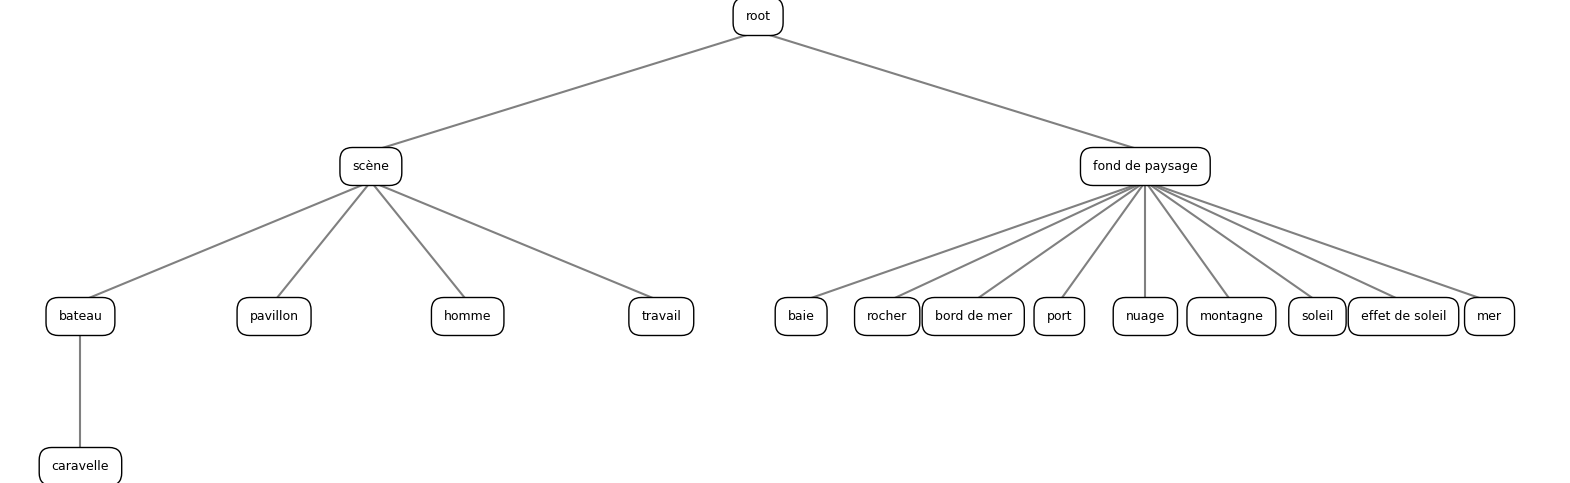

In [15]:
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms

def plot_tree(data, x=0, y=0, dx=1, dy=-1, ax=None, annotations=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(20, 6))
        ax.axis('off')
        if annotations is None:
            annotations = {}

    node_name = data['name']
    ax.text(x, y, node_name, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1.0'), fontsize=9)
    annotations[node_name] = (x, y)

    if 'children' in data and data['children']:
        num_children = len(data['children'])
        child_dx = dx / num_children
        start_x = x - (dx - child_dx) / 2

        for i, child in enumerate(data['children']):
            child_x = start_x + i * child_dx
            child_y = y + dy
            ax.plot([x, child_x], [y - 0.1, child_y + 0.1], 'gray', linestyle='-')
            plot_tree(child, child_x, child_y, dx / num_children, dy, ax, annotations)

tree = subjectMattersParsed[list(SUBJECTMATTER_DF["recordID"]).index(recordID)]["structured"]["subjectMatterSubjectTerms"]["tree"]
plot_tree(tree)
plt.show()

In [16]:
# We save this parsed subject matters
with open(FILE_SUBJECTMATTERS_PARSED, "w") as f:
    json.dump(subjectMattersParsed, f)

In [17]:
subjectMattersParsed = json.load(open(FILE_SUBJECTMATTERS_PARSED))
# Get a random entry
random_entry = subjectMattersParsed[random.randint(0, len(subjectMattersParsed)-1)]
import pprint
pprint.pprint(random_entry)

{'recordID': 10819,
 'structured': {'subjectMatterConceptualTerms': {'flattened': [], 'tree': {}},
                'subjectMatterIconographicTerms': {'flattened': [], 'tree': {}},
                'subjectMatterSubjectTerms': {'flattened': ['groupe de '
                                                            'figures'],
                                              'tree': {'children': [{'children': [],
                                                                     'name': 'groupe '
                                                                             'de '
                                                                             'figures'}],
                                                       'name': 'root'}}},
 'unstructured': {'subjectMatterGeneralSubjectDescription': nan,
                  'subjectMatterIconographicInterpretation': nan,
                  'subjectMatterSpecificSubjectIdentification': nan}}


# Analayze how "full" is the data

In [76]:
import numpy as np

def isEmpty(value):
    return pd.isna(value) or value is None or str(value) == "nan" or str(value) == "NaN" or len(str(value)) == 0

artpiece_columns = artpieces.columns
artist_columns = artists.columns
subject_matter_columns = SUBJECTMATTER_DF.columns

# Remove artistId from the artist columns
artist_columns = artist_columns[artist_columns != "creatorID"]
# We add the ArtistKnown column
artist_columns = list(artist_columns) + ["ArtistKnown"]

# Remove recordID from the subject matter columns
subject_matter_columns = subject_matter_columns[subject_matter_columns != "recordID"]

artpieces_empty_status = []

merged_columns = list(artpiece_columns) + list(artist_columns) + list(subject_matter_columns)

unknown_artist = 0
for recordID in tqdm(artpieces["recordID"]):
    # For each artwork, we check every column to see how many are nan
    artpiece_entry = artpieces.loc[artpieces["recordID"]==recordID]
    artist_id = artpiece_entry["creatorID"].values[0]
    artpiece_entry = artpiece_entry.values[0].tolist()

    # Get the artist entry (if it exists)
    isArtistUnknown = pd.isna(artist_id)    
    if isArtistUnknown:
        artist_entry = [np.nan] * (len(artist_columns) - 1 + 1) # -1 because we don't need the creatorID and +1 for the ArtistKnown column
    else:
        artist_entry = artists.loc[artists["creatorID"]==artist_id]
        # We remove the creatorID column
        artist_entry = artist_entry.drop(columns=["creatorID"])
        # We add the ArtistKnown column
        artist_entry["ArtistKnown"] = True
        artist_entry = artist_entry.values[0].tolist()

    unknown_artist += 1 if isArtistUnknown else 0

    # Get the subject matter entry (if it exists)
    subject_matter_entry = SUBJECTMATTER_DF.loc[SUBJECTMATTER_DF["recordID"]==recordID]
    # We remove the recordID column
    subject_matter_entry = subject_matter_entry.drop(columns=["recordID"])
    subject_matter_entry = subject_matter_entry.values[0].tolist()

    # Empty columns 
    artpiece_entry_empty = [isEmpty(x) for x in artpiece_entry]
    artist_entry_empty = [isEmpty(x) for x in artist_entry]
    subject_matter_entry_empty = [isEmpty(x) for x in subject_matter_entry]

    # subjectMatterSubjectTerms	subjectMatterIconographicTerms	subjectMatterConceptualTerms	subjectMatterIconographicInterpretation	subjectMatterGeneralSubjectDescription	subjectMatterSpecificSubjectIdentification
    L = [len(str(x)) for x in subject_matter_entry]
    # Merge into a single list
    merged_entry_empty = artpiece_entry_empty + artist_entry_empty + subject_matter_entry_empty

    # Add to the list
    artpieces_empty_status.append(merged_entry_empty)

print(f"Number of artworks with unknown artist: {unknown_artist}")
print(f"Number of artworks with known artist: {len(artpieces) - unknown_artist}")
print(f"Percentage of artworks with unknown artist: {unknown_artist / len(artpieces) * 100:.2f}%")
print(f"Percentage of artworks with known artist: {(len(artpieces) - unknown_artist) / len(artpieces) * 100:.2f}%")

# Get the recordIDs of rows with the least number of empty columns
merged_entry_empty_df = pd.DataFrame(artpieces_empty_status, columns=merged_columns)
merged_entry_empty_df["recordID"] = artpieces["recordID"]
merged_entry_empty_df.loc[merged_entry_empty_df["subjectMatterGeneralSubjectDescription"]==True].head(10)

100%|██████████| 5301/5301 [00:05<00:00, 949.74it/s] 

Number of artworks with unknown artist: 885
Number of artworks with known artist: 4416
Percentage of artworks with unknown artist: 16.69%
Percentage of artworks with known artist: 83.31%


,recordID,workID,creatorID,language,title,objectWorkType,termClassification,materials,signatureFullDescription,creationFullDescription,...,creatorNationality,creatorDeathDate,creatorBirthDate,ArtistKnown,subjectMatterSubjectTerms,subjectMatterIconographicTerms,subjectMatterConceptualTerms,subjectMatterIconographicInterpretation,subjectMatterGeneralSubjectDescription,subjectMatterSpecificSubjectIdentification
0,64,False,False,False,False,False,False,False,True,False,...,True,False,False,False,False,False,True,True,True,True
1,77,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,True,True,True,True
2,78,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,True
3,79,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,True
6,82,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,True
7,105,False,True,False,False,False,False,False,True,True,...,True,True,True,True,False,False,True,False,True,True
8,114,False,True,False,False,False,False,False,False,True,...,True,True,True,True,False,False,True,True,True,True
10,121,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,True,True
13,128,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,True
18,141,False,False,False,False,False,False,False,True,True,...,True,False,False,False,False,False,True,True,True,True


In [77]:
# Get the number of empty columns for each row
merged_entry_empty_df_temp = merged_entry_empty_df.copy()
merged_entry_empty_df_temp = merged_entry_empty_df_temp.drop(columns=["recordID"])
merged_entry_empty_df_temp["empty_columns"] = merged_entry_empty_df_temp.sum(axis=1)
merged_entry_empty_df_temp["recordID"] = merged_entry_empty_df["recordID"]

# Get the recordIDs
k = 5
ascending = False # True = least empty columns, False = most empty columns

merged_empty_status_sorted = merged_entry_empty_df_temp.sort_values(by="empty_columns", ascending=ascending)
topk_recordsIDs = merged_empty_status_sorted["recordID"].head(k).values.tolist()

In [78]:
artpieces_for_topk_recordsIDs = artpieces.loc[artpieces["recordID"].isin(topk_recordsIDs)]
artpieces_for_topk_recordsIDs

,recordID,workID,creatorID,language,title,objectWorkType,termClassification,materials,signatureFullDescription,creationFullDescription,...,physicalAppearanceDescription,imageType,imageColor,imageLowResFilename,imageHighResFilename,imageCopyright,formalDescriptionTermStylesPeriods,height,width,ratio
979,2162,692,NaN,fre,"Volet gauche, avers : Le baptême du Christ ; r...",triptyque (partie de),peinture (Dept. Art Ancien),bois,NaN,NaN,...,Bois,digitale JPG,photo couleurs,/art-foto/old/internet/DeCrayer-692LpanRdig-L.jpg,/art-foto/old/intranet/DeCrayer-692LpanRdig-H.jpg,NaN,NaN,NaN,NaN,NaN
1084,2334,1460,NaN,fre,Volets du retable de l'Agneau mystique. Avers ...,retable (partie de),peinture (Dept. Art Ancien),bois|chêne,NaN,NaN,...,Chêne,digitale JPG,photo couleurs,/art-foto/Old/internet/vanEyck-1460Lpanr-L.jpg,/art-foto/Old/intranet/vanEyck-1460Lpanr-H.jpg,NaN,NaN,NaN,NaN,NaN
2215,4861,7416,NaN,fre,"Triptyque des poissonniers de Bruges. Ouvert, ...",triptyque,peinture (Dept. Art Ancien),bois|chêne,Inscriptions sur le panneau central au milieu ...,NaN,...,Chêne,digitale JPG,photo couleurs,/art-foto/old/internet/Pourbus-7416dig-L.jpg,/art-foto/old/intranet/Pourbus-7416dig-H.jpg,NaN,NaN,NaN,NaN,NaN
4081,8461,11659 - 11673,NaN,fre,Le panorama du siècle : dessins préparatoires,dessin,oeuvre sur papier (Dept. Art Moderne),crayon|encre de Chine|papier,NaN,NaN,...,NaN,digitale JPG,photo couleurs,/art-foto/mod/internet/Stevens-11659dig-L.jpg,/art-foto/mod/intranet/Stevens-11659dig-H.jpg,NaN,NaN,NaN,NaN,NaN
4086,8484,6074 - 6077,NaN,fre,Le panorama du siècle,tableau (toile),peinture (Dept. Art Moderne),toile|peinture à l'huile,NaN,NaN,...,NaN,ektachrome (MRBAB),photo couleurs,/art-foto/mod/internet/Stevens-Gervex-6074-L.jpg,/art-foto/mod/intranet/Stevens-Gervex-6074-H.jpg,NaN,NaN,NaN,NaN,NaN


In [79]:
artists_for_topk_recordsIDs = artists.loc[artists["creatorID"].isin(artpieces_for_topk_recordsIDs["creatorID"].values.tolist())]
artists_for_topk_recordsIDs

,creatorID,creatorLastName,creatorFirstName,creatorBirthAndDeathDescription,creatorNationality,creatorDeathDate,creatorBirthDate
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
subject_matter_for_topk_recordsIDs = SUBJECTMATTER_DF.loc[SUBJECTMATTER_DF["recordID"].isin(topk_recordsIDs)]
subject_matter_for_topk_recordsIDs

,recordID,subjectMatterSubjectTerms,subjectMatterIconographicTerms,subjectMatterConceptualTerms,subjectMatterIconographicInterpretation,subjectMatterGeneralSubjectDescription,subjectMatterSpecificSubjectIdentification
979,2162,NaN,NaN,NaN,NaN,NaN,NaN
1084,2334,NaN,NaN,NaN,NaN,NaN,NaN
2215,4861,NaN,NaN,NaN,NaN,NaN,NaN
4081,8461,NaN,NaN,NaN,NaN,NaN,NaN
4086,8484,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
merged_entry_empty_df

,recordID,workID,creatorID,language,title,objectWorkType,termClassification,materials,signatureFullDescription,creationFullDescription,...,creatorNationality,creatorDeathDate,creatorBirthDate,ArtistKnown,subjectMatterSubjectTerms,subjectMatterIconographicTerms,subjectMatterConceptualTerms,subjectMatterIconographicInterpretation,subjectMatterGeneralSubjectDescription,subjectMatterSpecificSubjectIdentification
0,64,False,False,False,False,False,False,False,True,False,...,True,False,False,False,False,False,True,True,True,True
1,77,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,True,True,True,True
2,78,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,True
3,79,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,True
4,80,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5296,13322,False,False,False,False,False,False,False,True,True,...,False,False,False,False,True,True,True,True,True,True
5297,13323,False,False,False,False,False,False,False,True,True,...,True,False,False,False,True,True,True,True,True,True
5298,13377,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,True,True,True,True,True
5299,13379,False,False,False,False,False,False,False,False,True,...,False,False,False,False,True,True,True,True,True,True


In [82]:
"""
Get subject matter subject terms that:
1) Is defined as not empty in merged_entry_empty_df
2) Has a small length
"""
rows_with_not_empty_subject_matter = merged_entry_empty_df[merged_entry_empty_df["subjectMatterSubjectTerms"]==False]
lengths_subject_matter = {}
for i in range(len(rows_with_not_empty_subject_matter)):
    recordID = rows_with_not_empty_subject_matter.iloc[i]["recordID"]
    subject_matter_entry = SUBJECTMATTER_DF.loc[SUBJECTMATTER_DF["recordID"]==recordID]["subjectMatterSubjectTerms"].values[0]
    length = len(str(subject_matter_entry))
    lengths_subject_matter[recordID] = length

# Sort by length (ascending)
sorted_lengths_subject_matter = sorted(lengths_subject_matter.items(), key=lambda x: x[1])
# Get the top k records with the smallest length
k = 5
topk_recordsIDs = [x[0] for x in sorted_lengths_subject_matter[:k]]
for recordID in topk_recordsIDs:
    length = lengths_subject_matter[recordID]
    entry = SUBJECTMATTER_DF.loc[SUBJECTMATTER_DF["recordID"]==recordID]["subjectMatterSubjectTerms"].values[0]
    print(f"Record ID: {recordID}, Length: {length}, Entry: {entry}")



Record ID: 4568, Length: 3, Entry: mer
Record ID: 2096, Length: 4, Entry: tête
Record ID: 6483, Length: 4, Entry: main
Record ID: 10123, Length: 4, Entry: pied
Record ID: 852, Length: 5, Entry: fruit


In [83]:
merged_entry_empty_df_wo_recordID = merged_entry_empty_df.copy()
merged_entry_empty_df_wo_recordID = merged_entry_empty_df_wo_recordID.drop(columns=["recordID"])
merged_entry_empty_df_wo_recordID.loc[merged_entry_empty_df_wo_recordID["subjectMatterGeneralSubjectDescription"]==False]

,workID,creatorID,language,title,objectWorkType,termClassification,materials,signatureFullDescription,creationFullDescription,creationEarliestDate,...,creatorNationality,creatorDeathDate,creatorBirthDate,ArtistKnown,subjectMatterSubjectTerms,subjectMatterIconographicTerms,subjectMatterConceptualTerms,subjectMatterIconographicInterpretation,subjectMatterGeneralSubjectDescription,subjectMatterSpecificSubjectIdentification
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
9,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
11,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
12,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1591,False,False,False,False,False,False,False,True,True,False,...,True,False,False,False,False,False,True,False,False,False
1594,False,False,False,False,False,False,False,True,True,True,...,True,False,False,False,False,False,False,False,False,False
1595,False,True,False,False,False,False,False,False,True,False,...,True,True,True,True,False,False,False,False,False,False
2153,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False


Figure saved in:  ./../.././public/figures/availability_per_column.pdf


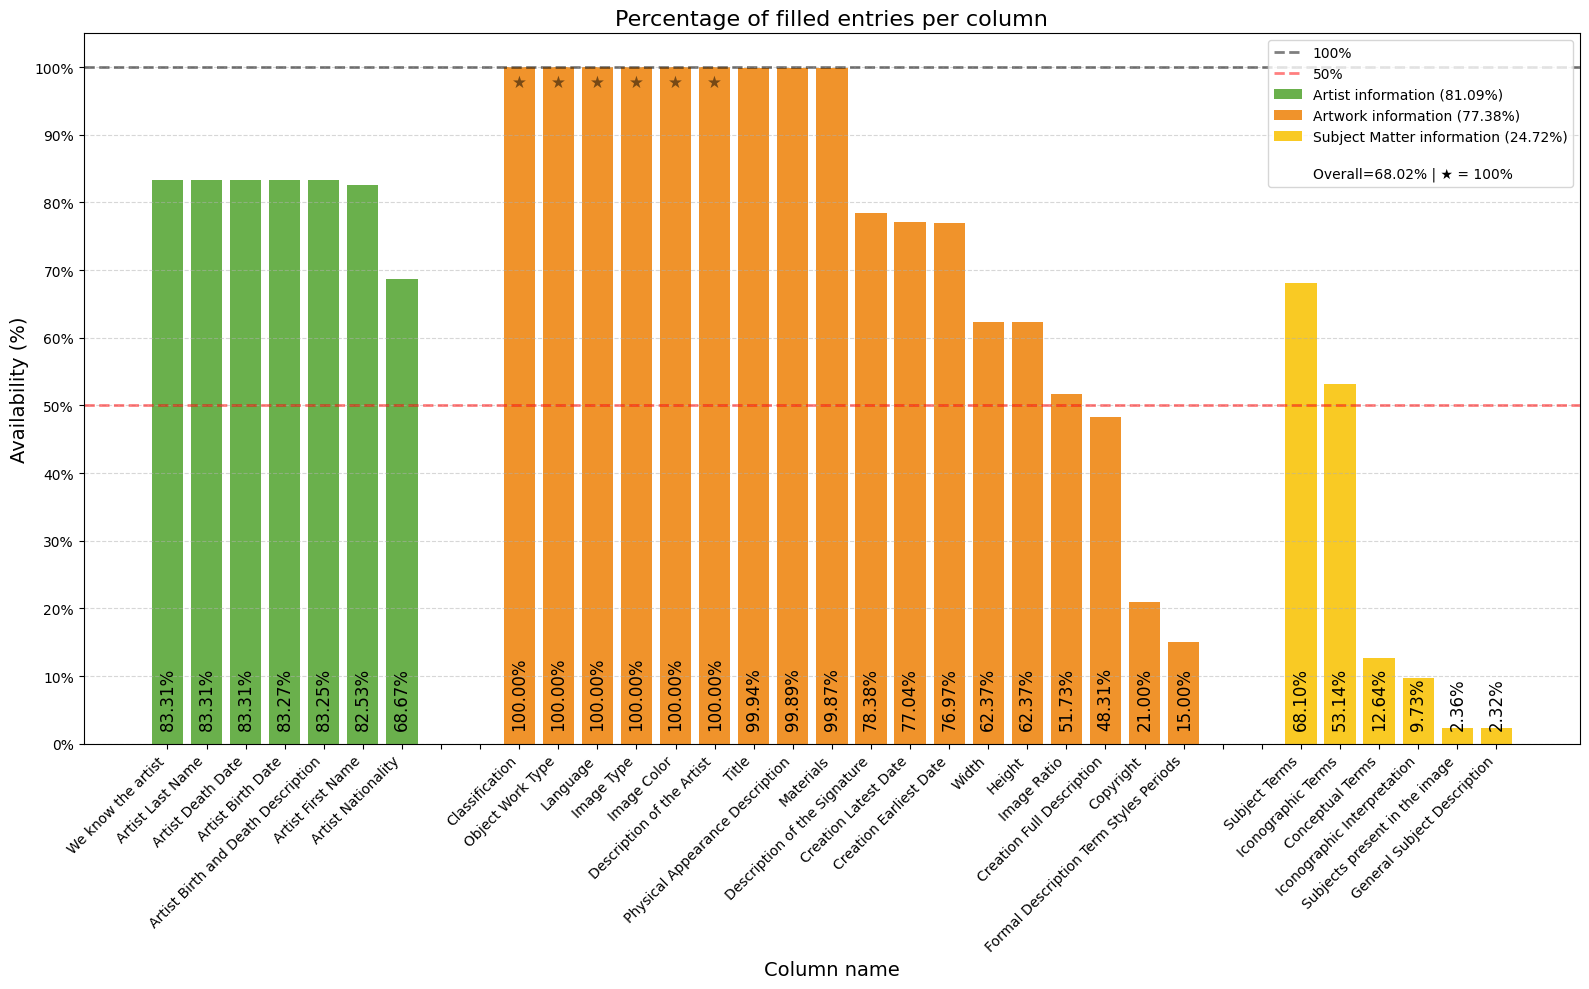

In [96]:
creator_columns = {
    'ArtistKnown': 'We know the artist',
    'creatorFirstName': 'Artist First Name',
    'creatorLastName': 'Artist Last Name',
    'creatorBirthDate': 'Artist Birth Date',
    'creatorDeathDate': 'Artist Death Date',
    'creatorBirthAndDeathDescription': 'Artist Birth and Death Description',
    'creatorNationality': 'Artist Nationality',
}

artpiece_columns = {
    'title': 'Title',
    'creatorFullDescription': 'Description of the Artist',
    'signatureFullDescription': 'Description of the Signature',
    'imageCopyright': 'Copyright',
    'imageType': 'Image Type',
    'physicalAppearanceDescription': 'Physical Appearance Description',
    'language': 'Language',
    'materials': 'Materials',
    'termClassification': 'Classification',
    'objectWorkType': 'Object Work Type',
    'imageColor': 'Image Color',
    'formalDescriptionTermStylesPeriods': 'Formal Description Term Styles Periods',
    'creationFullDescription': 'Creation Full Description',
    'creationEarliestDate': 'Creation Earliest Date',
    'creationLatestDate': 'Creation Latest Date',
    'ratio': 'Image Ratio',
    'width': 'Width',
    'height': 'Height',  
}

subject_matter_columns = {
    'subjectMatterSpecificSubjectIdentification': 'Subjects present in the image',
    'subjectMatterIconographicInterpretation': 'Iconographic Interpretation',
    'subjectMatterConceptualTerms': 'Conceptual Terms',
    'subjectMatterGeneralSubjectDescription': 'General Subject Description',
    'subjectMatterSubjectTerms': 'Subject Terms',
    'subjectMatterIconographicTerms': 'Iconographic Terms',
}

bar_colors_hex = {
    "Artist information": "#6ab04c",
    "Artwork information": "#f0932b",
    "Subject Matter information": "#f9ca24",
}

# Order by y value the subroups
creator_columns_ordered = []
artpiece_columns_ordered = []
subject_matter_columns_ordered = []

for column in creator_columns:
    empty_entries = merged_entry_empty_df_wo_recordID[column].value_counts(normalize=True) * 100
    if not False in empty_entries:
        empty_entries_val = 1.0
    else:
        empty_entries_val = empty_entries[False]
    creator_columns_ordered.append((column, empty_entries_val))

for column in artpiece_columns:
    empty_entries = merged_entry_empty_df_wo_recordID[column].value_counts(normalize=True) * 100
    if not False in empty_entries:
        empty_entries_val = 1.0
    else:
        empty_entries_val = empty_entries[False]
    artpiece_columns_ordered.append((column, empty_entries_val))

for column in subject_matter_columns:
    empty_entries = merged_entry_empty_df_wo_recordID[column].value_counts(normalize=True) * 100
    if not True in empty_entries:
        empty_entries_val = 0.0
    else:
        empty_entries_val = empty_entries[False]
    subject_matter_columns_ordered.append((column, empty_entries_val))

# Sort by y value
def sortHack(x):
    if x[0]=="ArtistKnown":
        return (101, "AAA") # I want this to be the first one !
    else:
        return (x[1], x[0])
    
creator_columns_ordered = sorted(creator_columns_ordered, key=lambda x: sortHack(x), reverse=True)
artpiece_columns_ordered = sorted(artpiece_columns_ordered, key=lambda x: (x[1], x[0]), reverse=True)
subject_matter_columns_ordered = sorted(subject_matter_columns_ordered, key=lambda x: (x[1], x[0]), reverse=True)

average_creator_columns = sum([x[1] for x in creator_columns_ordered]) / len(creator_columns_ordered)
average_artpiece_columns = sum([x[1] for x in artpiece_columns_ordered]) / len(artpiece_columns_ordered)
average_subject_matter_columns = sum([x[1] for x in subject_matter_columns_ordered]) / len(subject_matter_columns_ordered)
overall_average = []
for column, empty_entries_val in creator_columns_ordered:
    overall_average.append(empty_entries_val)
for column, empty_entries_val in artpiece_columns_ordered:
    overall_average.append(empty_entries_val)
for column, empty_entries_val in subject_matter_columns_ordered:
    overall_average.append(empty_entries_val)
overall_average = sum(overall_average) / len(overall_average)

averages = [average_creator_columns, average_artpiece_columns, average_subject_matter_columns]

space = 2

# Vertical bar plot 
fig, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Percentage of filled entries per column", fontsize=16)
ax.set_ylabel("Availability (%)", fontsize=14)
ax.set_xlabel("Column name", fontsize=14)
ax.set_ylim(0, 105)

bar_x = []
bar_x_labels = []
bar_y = []
bar_colors = []
bar_labels = []

x = 0

for column, empty_entries_val in creator_columns_ordered:
    column_name = creator_columns[column]
    bar_x.append(x)
    bar_x_labels.append(column_name)
    bar_y.append(empty_entries_val)
    bar_colors.append(bar_colors_hex["Artist information"])
    bar_labels.append(column_name)
    x += 1

# Add a space between the bars
for i in range(space):
    bar_x.append(x)
    bar_y.append(0)
    bar_x_labels.append("")
    bar_colors.append("#FFFFFF")
    bar_labels.append("")
    x += 1

for column, empty_entries_val in artpiece_columns_ordered:
    column_name = artpiece_columns[column]
    bar_x.append(x)
    bar_x_labels.append(column_name)
    bar_y.append(empty_entries_val)
    bar_colors.append(bar_colors_hex["Artwork information"])
    bar_labels.append(column_name)

    x += 1

# Add a space between the bars
for i in range(space):
    bar_x.append(x)
    bar_y.append(0)
    bar_x_labels.append("")
    bar_colors.append("#FFFFFF")
    bar_labels.append("")
    x += 1

for column, empty_entries_val in subject_matter_columns_ordered:
    column_name = subject_matter_columns[column]
    bar_x.append(x)
    bar_x_labels.append(column_name)
    bar_y.append(empty_entries_val)
    bar_colors.append(bar_colors_hex["Subject Matter information"])
    bar_labels.append(column_name)

    x += 1

plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add an horizontal line at y=100
ax.axhline(y=100, color='black', linestyle='--', linewidth=2.0, label='100%', alpha=0.5)
# Add a horizontal line at y=50
ax.axhline(y=50, color='red', linestyle='--', linewidth=2.0, label='50%', alpha=0.5)

# Plot the bar
ax.bar(bar_x, bar_y, color=bar_colors, tick_label=bar_x_labels, width=0.8)

# Add a text at the bottom of the bar
for i in range(len(bar_x)):
    x = bar_x[i]
    y = bar_y[i]
    label = bar_labels[i]
    if label != "":
        text = f"{y:.2f}%"
        ax.text(x, 2, text, ha='center', va='bottom', fontsize=12, rotation=90, color="black")
        if y==100:
            # Add a star on the top of the bar
            ax.text(x, 96.5, "★", ha='center', va='bottom', fontsize=12, color="black", alpha=0.5)

# Add to the legend the subgroups
for i, key in enumerate(bar_colors_hex):
    ax.bar(0, 0, color=bar_colors_hex[key], label=f"{key} ({averages[i]:.2f}%)")

yticks = range(0, 101, 10)
ax.set_yticks(yticks)
ax.set_yticklabels([str(x) + "%" for x in yticks], fontsize=10)

# Add a legend for the overall average and for the star (100%)
ax.bar(0, 0, color="white", label=f"\nOverall={overall_average:.2f}% | ★ = 100%", alpha=0.0)

# Rotate the x-axis labels
plt.legend(loc='upper right', fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.savefig(FOLDER_FIGURES + "availability_per_column.pdf", dpi=300, bbox_inches='tight')
print("Figure saved in: ", FOLDER_FIGURES + "availability_per_column.pdf")
plt.show()

In [161]:
from Levenshtein import distance

# Get k examples where we don't know the artist but we have the Description of the artist
k = -1
artpieces_for_unknown_artist = merged_entry_empty_df[merged_entry_empty_df["ArtistKnown"]==True]
artpieces_for_unknown_artist = artpieces_for_unknown_artist[artpieces_for_unknown_artist["creatorFullDescription"]==False]
if k > 0:
    artpieces_for_unknown_artist = artpieces_for_unknown_artist.sample(n=k, random_state=0)
recordIDs = artpieces_for_unknown_artist["recordID"].values.tolist()

# Get the creatorFullDescription for each recordID
predictions = {}
for recordID in tqdm(recordIDs):
    creatorFullDescription = artpieces.loc[artpieces["recordID"]==recordID]["creatorFullDescription"].values[0]
    creatorID = artpieces.loc[artpieces["recordID"]==recordID]["creatorID"].values[0]

    words = creatorFullDescription.split(" ")

    # Find the closest artist (least diffenent name) using the Levenshtein distance
    distances = {}
    for i in range(len(artists)):
        artist = artists.iloc[i]
        artistID = artist["creatorID"]
        if pd.isna(artistID):
            continue

        firstName = str(artist["creatorFirstName"])
        lastName = str(artist["creatorLastName"])

        fullName = f"{firstName} {lastName}"
        
        firstNameAppears = firstName in words
        lastNameAppears = lastName in words
        
        firstNameAppears = 1 if firstNameAppears else 0
        lastNameAppears = 1 if lastNameAppears else 0

        levensthein_distance = distance(creatorFullDescription, fullName)
        distances[artistID] =  (1 + firstNameAppears + lastNameAppears) / (levensthein_distance + 1e-10) 

    # Sort by distance
    sorted_distances = sorted(distances.items(), key=lambda x: x[1], reverse=True)
    # Get the top k closest artists
    k = 10
    top_k_closest_artists = sorted_distances[:k]
    isAnyExact = False
    pred_for_recordID = []
    for index, (artistID, dist) in enumerate(top_k_closest_artists):
        artist = artists.loc[artists["creatorID"]==artistID]
        firstName = artist["creatorFirstName"].values
        lastName = artist["creatorLastName"].values

        if len(firstName) == 0 or pd.isna(firstName[0]):
            firstName = ""
        else:
            firstName = firstName[0]

        if len(lastName) == 0 or pd.isna(lastName[0]):
            lastName = ""
        else:
            lastName = lastName[0]
            
        artistName = f"{firstName} {lastName}"
        if artistName in creatorFullDescription:
            isAnyExact = True

        pred_for_recordID.append(artistName)

    predictions[recordID] = [isAnyExact, creatorFullDescription] + pred_for_recordID

# Make pandas dataframe
predictions_df = pd.DataFrame(predictions).T
predictions_df.columns = ["Any exact", "creatorFullDescription"] + [f"Prediction {i+1}" for i in range(k)]
predictions_df = predictions_df.reset_index()
predictions_df = predictions_df.rename(columns={"index": "recordID"})
predictions_df

100%|██████████| 885/885 [00:36<00:00, 24.34it/s]


,recordID,Any exact,creatorFullDescription,Prediction 1,Prediction 2,Prediction 3,Prediction 4,Prediction 5,Prediction 6,Prediction 7,Prediction 8,Prediction 9,Prediction 10
0,105,True,Jan I Brueghel ; figures de Hendrick van Balen,Hendrick van Balen,Jan I Brueghel,Jan II Brueghel,Hendrick Staben,Jan van Delen,Hendrick Cassiers,Hendrick de Clerck,Hendrick Goovaerts,Jan van Kessel I,Jan van Bijlert
1,114,False,Rienk Keyert,Rik Wouters,Léon Gobert,Franz Meerts,Jan Fyt,Hubert Robert,Berthe Art,Louis Royer,Jean Geefs,Vital Keuller,Fanny Geefs
2,288,False,Pieter I Bruegel,Pieter II Brueghel,Pieter Boel,Pieter Aertsen,Pieter Bout,Pieter Baltens,Pieter Pourbus,Pieter Oyens,Pieter Angillis,Pieter van Avont,Pieter Thys I
3,293,False,Frans II Boudewijns ?,Frans Van Holder,Frans Hens,Frans Snijders,Frans de Momper,Frans Huygelen,Frans Gailliard,Frans Vervloet,Frans van Leemputten,Frans II Pourbus,Frans I Pourbus
4,294,True,Jan Claudius de Cock,Jan Claudius de Cock,Jan Van Beers,Jan Cossiers,Jan van Kessel I,Jan Wildens,Jan van Delen,Jan Massys,Jan van Bijlert,Jan Provoost,Jan Stobbaerts
...,...,...,...,...,...,...,...,...,...,...,...,...,...
880,11545,False,Barbara Regina Dietzsch (entourage de),Jean-Antoine Verschaeren,François Verheyden,Rogier van der Weyden,Francesco Guardi,Frits Van den Berghe,Abraham Sigmund August von Bonstetten,Ferdinand De Braekeleer,Bonifazio Veronese,Eugène de Suède (prince),Adriaen De Gryef
881,11594,False,Anonyme (Ecole des Pays-Bas méridionaux),Ecole des Pays-Bas méridionaux,Ecole des Pays-Bas méridionaux,Ecole des Pays-Bas méridionaux,Ecole des Pays-Bas septentrionaux,Ecole des Pays-Bas septentrionaux,Ecole des Pays-Bas septentrionaux,Eugène de Suède (prince),Ecole française,Ecole française,Andrés de Santa Maria
882,11668,True,Constantin Meunier,Constantin Meunier,George Meunier,Constance Mayer,Constant Montald,Constant Troyon,Constantin Fidèle Coene,Joachim Patenier,Vital Keuller,Ernest Slingeneyer,Johann Heiss
883,12069,False,Henri ou Max Moreau (attribué à),Henri de Toulouse-Lautrec,Henri van der Poorten,Henri Marcette,Henri Martin,Henri De Braekeleer,Henri de Caisne,Henri Fantin-Latour,Henri Van der Hecht,Henri Vanderhaert,Henri Manguin


In [163]:
# Get the percentage of exact matches
predictions_df["Any exact"].value_counts()

Any exact
False    653
True     232
Name: count, dtype: int64

In [165]:
# Save the predictions
predictions_df.to_csv(AUTHORS_PREDICTIONS, index=False)

In [222]:
# Get the unique values of the subject matter fields
subject_matter_columns = ["subjectMatterSubjectTerms", "subjectMatterIconographicTerms", "subjectMatterConceptualTerms"]

unique_values = {}
for columnName in subject_matter_columns:
    unique_values[columnName] = set()
    for i in range(len(subjectMattersParsed)):
        flattened_values = subjectMattersParsed[i]["structured"][columnName]["flattened"]
        unique_values[columnName].update(flattened_values)

non_null_entries_per_column = {}
for columnName in subject_matter_columns:
    non_null_entries_per_column[columnName] = 0
    for i in range(len(subjectMattersParsed)):
        flattened_values = subjectMattersParsed[i]["structured"][columnName]["flattened"]
        if len(flattened_values) > 0:
            non_null_entries_per_column[columnName] += 1

# Get the number of unique values
for column in unique_values:
    print(f"Number of unique values for {column}: {len(unique_values[column])}")

# Merge the three sets
merged_set = set()
for column in unique_values:
    merged_set.update(unique_values[column])

total_nUnique = [len(values_set) for values_set in unique_values.values()]

print(f"Total number of unique values for all subject matter fields: {sum(total_nUnique)}")
print(f"Number of unique values for all subject matter fields: {len(merged_set)}")
intersection_ratio = len(merged_set) / sum(total_nUnique)
print(f"Intersection ratio: {intersection_ratio:.2f}")

table_stats = pd.DataFrame(columns=["Field", "Number of unique values", "Number of entries", "Unique value ratio"])
for column in unique_values:
    table_stats.loc[len(table_stats)] = [column, len(unique_values[column]), non_null_entries_per_column[column], len(unique_values[column]) / non_null_entries_per_column[column]]

table_stats.loc[len(table_stats)] = ["All subject matter fields", len(merged_set), sum(non_null_entries_per_column.values()), len(merged_set) / sum(non_null_entries_per_column.values())]

table_stats = table_stats.reset_index(drop=True)
table_stats.to_csv(FOLDER_TABLE + "subject_matter_unique_values.csv", index=False)
table_stats

Number of unique values for subjectMatterSubjectTerms: 1422
Number of unique values for subjectMatterIconographicTerms: 2573
Number of unique values for subjectMatterConceptualTerms: 636
Total number of unique values for all subject matter fields: 4631
Number of unique values for all subject matter fields: 3860
Intersection ratio: 0.83


,Field,Number of unique values,Number of entries,Unique value ratio
0,subjectMatterSubjectTerms,1422,3610,0.393906
1,subjectMatterIconographicTerms,2573,2817,0.913383
2,subjectMatterConceptualTerms,636,670,0.949254
3,All subject matter fields,3860,7097,0.543892


In [225]:
# Get the number of capital letter words in the subject matter fields
subject_matter_columns = ["subjectMatterSubjectTerms", "subjectMatterIconographicTerms", "subjectMatterConceptualTerms"]
capital_letters_counts = {}
for columnName in subject_matter_columns:
    capital_letters_counts[columnName] = 0
    values_set = unique_values[columnName]
    for value in values_set:
        containCapitalLetter = value.lower() != value
        if containCapitalLetter:
            capital_letters_counts[columnName] += 1
    

capital_letters_counts_df = pd.DataFrame(capital_letters_counts.items(), columns=["Field", "Number of capital letter words"])
capital_letters_counts_df["Number of unique classes"] = [len(unique_values[columnName]) for columnName in capital_letters_counts_df["Field"].values]
capital_letters_counts_df["Percentage"] = capital_letters_counts_df["Number of capital letter words"] / capital_letters_counts_df["Number of unique classes"]
capital_letters_counts_df["Percentage"] = capital_letters_counts_df["Percentage"].apply(lambda x: f"{x:.2%}")
capital_letters_counts_df = capital_letters_counts_df.reset_index(drop=True)
capital_letters_counts_df.to_csv(FOLDER_TABLE + "subject_matter_capital_letters.csv", index=False)
capital_letters_counts_df

,Field,Number of capital letter words,Number of unique classes,Percentage
0,subjectMatterSubjectTerms,26,1422,1.83%
1,subjectMatterIconographicTerms,1713,2573,66.58%
2,subjectMatterConceptualTerms,322,636,50.63%


In [230]:
# Get the count per class
counts_per_class = {}
for class_name in merged_set:
    counts_per_class[class_name] = 0

for columnName in subject_matter_columns:
    for i in range(len(subjectMattersParsed)):
        flattened_values = subjectMattersParsed[i]["structured"][columnName]["flattened"]
        for value in flattened_values:
            counts_per_class[value] += 1

# Sort the counts per class
sorted_counts_per_class = sorted(counts_per_class.items(), key=lambda x: x[1], reverse=True)

In [235]:
classes_below_10 = []
for class_name, count in sorted_counts_per_class[::-1]:
    if count <= 10:
        classes_below_10.append((class_name, count))
    else:
        break

top10_classes = sorted_counts_per_class[:10]
print(f"Number of classes with less than 10 entries: {len(classes_below_10)}")
print(f"Number of classes with more than 10 entries: {len(sorted_counts_per_class) - len(classes_below_10)}")
print(len(classes_below_10)/len(sorted_counts_per_class))

Number of classes with less than 10 entries: 3339
Number of classes with more than 10 entries: 521
0.8650259067357513


In [237]:
threshold_005 = np.ceil(0.05 * len(subjectMattersParsed))
print(f"Threshold for 5%: {threshold_005}")

classes_above_threshold = []
for class_name, count in sorted_counts_per_class:
    if count > threshold_005:
        classes_above_threshold.append((class_name, count))
    else:
        break

top10_classes = sorted_counts_per_class[:10]
print(f"Number of classes above 5%: {len(classes_above_threshold)}")

classes_above_threshold_classes = []
classes_above_threshold_counts = []

for class_name, count in classes_above_threshold:
    classes_above_threshold_classes.append(class_name)
    classes_above_threshold_counts.append(count)

# Make a pandas dataframe
classes_above_threshold_df = pd.DataFrame({
    "Class": classes_above_threshold_classes,
    "Count": classes_above_threshold_counts
})
classes_above_threshold_df["Percentage"] = classes_above_threshold_df["Count"] / len(subjectMattersParsed) * 100
classes_above_threshold_df["Percentage"] = classes_above_threshold_df["Percentage"].apply(lambda x: f"{x:.2f}%")
classes_above_threshold_df = classes_above_threshold_df.sort_values(by="Count", ascending=False)
classes_above_threshold_df = classes_above_threshold_df.reset_index(drop=True)
classes_above_threshold_df.to_csv(FOLDER_TABLE + "classes_above_threshold.csv", index=False)
classes_above_threshold_df

Threshold for 5%: 266.0
Number of classes above 5%: 25


,Class,Count,Percentage
0,homme,1861,35.11%
1,figure,1436,27.09%
2,femme,1367,25.79%
3,groupe de figures,972,18.34%
4,animal,822,15.51%
5,paysage,663,12.51%
6,portrait,660,12.45%
7,scène,641,12.09%
8,arbre,633,11.94%
9,enfant,543,10.24%


In [215]:
classes_above_threshold_100_app = []
for class_name, count in sorted_counts_per_class:
    if count >= 100:
        classes_above_threshold_100_app.append((class_name, count))
    else:
        break

print(f"Number of classes with more than 100 appearances: {len(classes_above_threshold_100_app)}")

Number of classes with more than 100 appearances: 81
